# Probing Syntax in LLMs
by Lars Kulbe, Maxim Kurvink & Ole Jürgensen

#### Import libraries

In [143]:
import os
import requests
import re
import sys
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx


import transformer_lens
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import optim

from io import StringIO, BytesIO
from conllu import parse_incr
from IPython.display import Image, display
from PIL import Image as PILImage


## Introduction to Parsing Trees & Dataset

### Parsing Trees

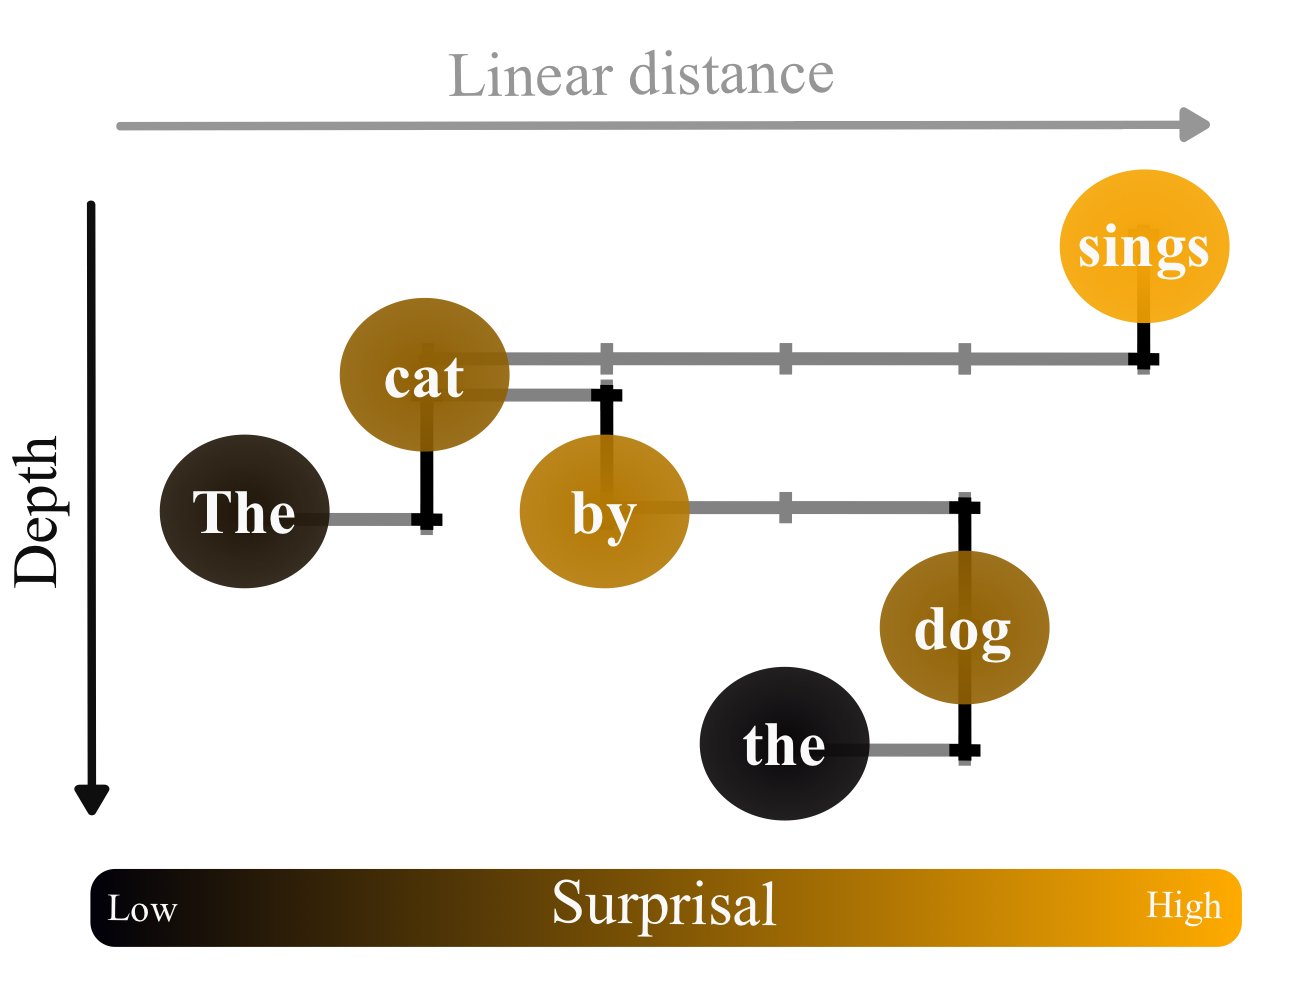

In [144]:
image_path = "images/tree_example.jpeg"
display(Image(filename=image_path, width=400, height=300))

The image adapted from Diego-Simon et al. (2025) depicts a typical **dependency-based parse** tree for a short sentence. Nodes in the tree represent words, and edges represent immediate dependencies. Nodes that connect to a lower-level node are referred to as that node’s **parent**, while the lower-level node is called the **child**. At the lowest depth, we find the **root** of the sentence (sings), which is the main verb of the sentence. The children of a node can be thought of as adding information to the parent. In this example, the prepositional phrase “by the dog” modifies the subject “cat.”

To construct these trees, we require hand-annoted sentences. We use the Universal Dependencies - English Dependency Treebank (v2.17 -- 2025-11-15) data, which is openly available on their GitHub repository.

In [145]:
def get_data():
    sentences_train = []
    sentences_test = []

    root_url = "https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/"
    
    files = {
        "test": "en_ewt-ud-test.conllu", 
        "train": "en_ewt-ud-train.conllu"
        }

    for key, file in files.items():
        file_url = os.path.join(root_url, file)
        response = requests.get(file_url)
        response.raise_for_status()


        file_content = StringIO(response.text)
        for sentence in parse_incr(file_content):
            if key == "test":
                sentences_test.append(sentence)
            if key == "train":
                sentences_train.append(sentence)

    # exlude email addresses and URLs
    email_pattern = re.compile(r'\S+@\S+')
    url_pattern = re.compile(r'http\S+|www\S+')

    sentences_train = [s for s in sentences_train if not email_pattern.search(s.metadata["text"]) and not url_pattern.search(s.metadata["text"])]
    sentences_test =  [s for s in sentences_test  if not email_pattern.search(s.metadata["text"]) and not url_pattern.search(s.metadata["text"])]
    
    return sentences_train, sentences_test

sentences_train, sentences_test = get_data()
print("There are {} training sentences and {} test sentences.".format(len(sentences_train), len(sentences_test)))

There are 12279 training sentences and 2004 test sentences.


Print some example sentences:

In [146]:
for i in np.random.randint(0, len(sentences_train), size = 5):
    print(sentences_train[i].metadata["text"])

THIS STORY IS 100% TRUE.
the passcode: 6871082#
A few more years may pass before everybody acknowledges that it is a World War, but we are already well into it.
I could have stayed all day and not seen all the things.
Your comments to the transfer agreement were fine.


The dependecy tree structure can be decribed by a single variable (head), specifying the **parent** of a given word.

In [147]:
idx = 59
print(sentences_test[idx].metadata["text"])
print("")
for tok in sentences_test[idx]:
    print(str(tok['id']).ljust(3), tok['form'].ljust(12), ' --> ', sentences_test[idx][tok['head']-1]['form'] if tok['head'] != 0 else 'ROOT')

I had to go to the BBC for this report .

1   I             -->  had
2   had           -->  ROOT
3   to            -->  go
4   go            -->  had
5   to            -->  BBC
6   the           -->  BBC
7   BBC           -->  go
8   for           -->  report
9   this          -->  report
10  report        -->  go
11  .             -->  had


Based on this we can reconstruct the parse tree distances using the lowest common ancestor (LCA; not to be confused with Latent Class Analysis). Direct links have a distance of 1, if there is one node sperating, them the distance is 2, and so on.

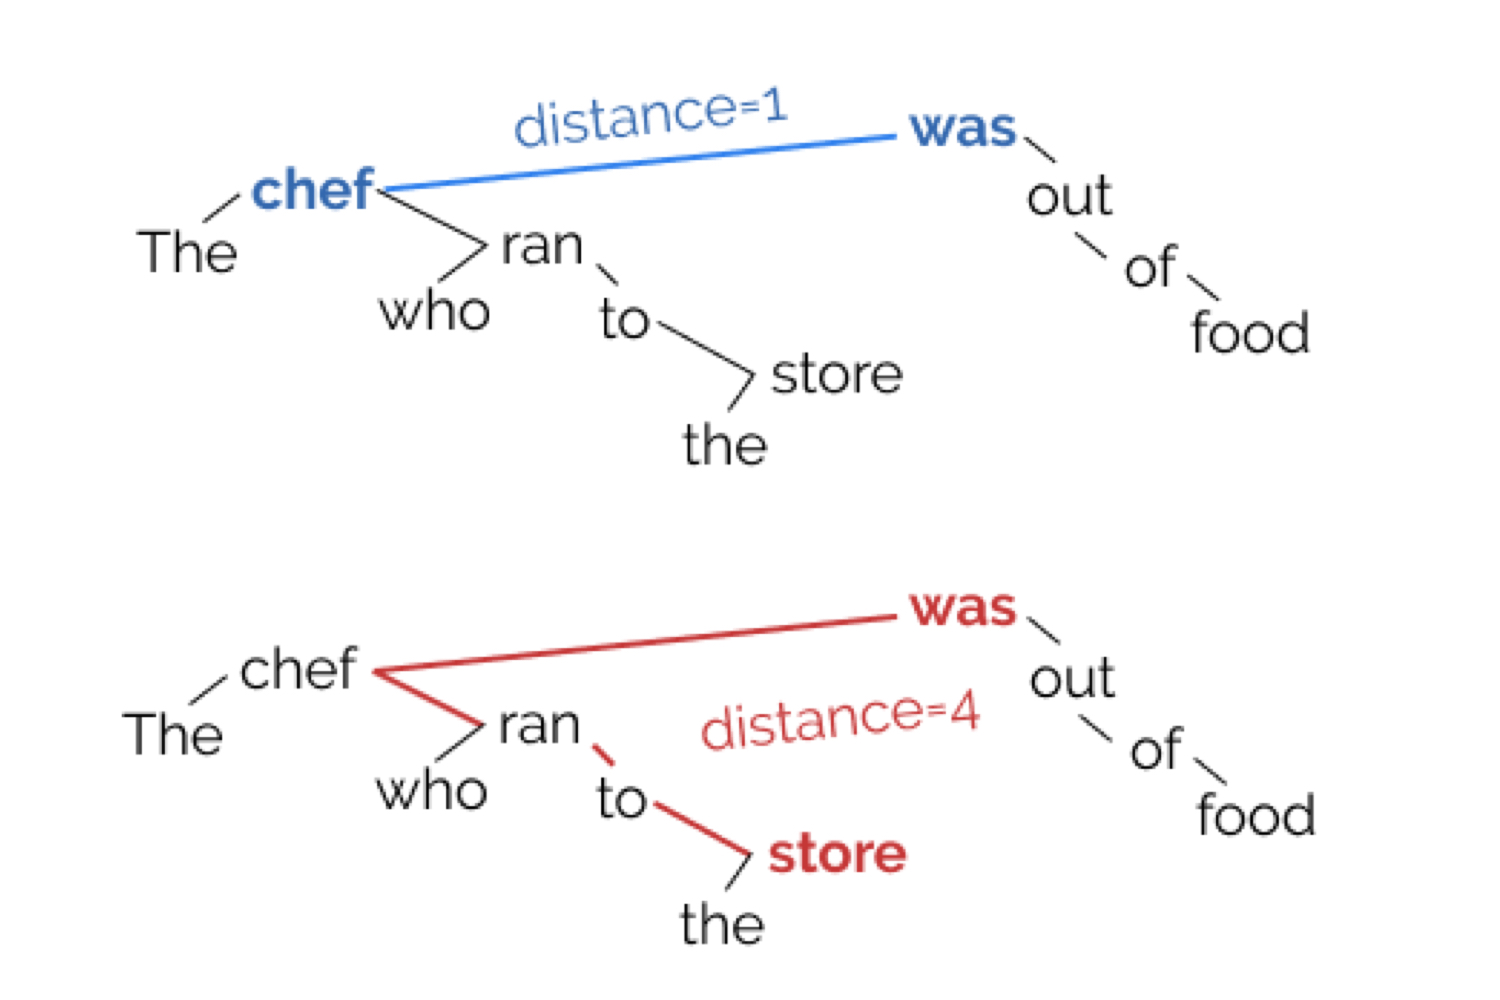

In [148]:
# example from Hewitt and Manning (2019)
image_path = "images/distance_scheme.jpeg"
display(Image(filename=image_path, width=400, height = 300))

### Define Functions

Below is a custom function to get syntactic tree distances from our annotated sentences

<Axes: >

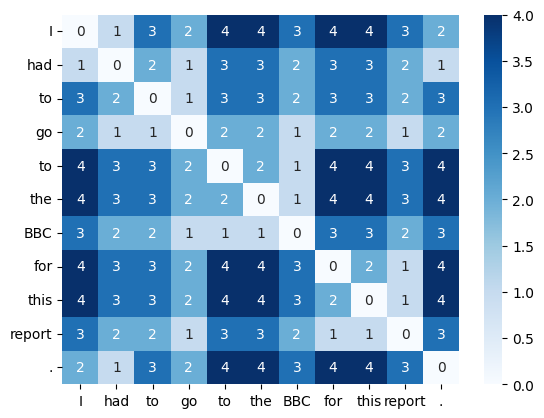

In [149]:
# expand to see function
def distance_matrix_from_sentence(sentence):
    """
    Return (matrix, ids) where matrix[i,j] is the discrete tree distance
    (number of edges) between token ids[i] and ids[j].
    Expects tokens with integer 'id' and 'head' (head==0 means ROOT).
    """

    forms = [tok['form'] for tok in sentence]
    ids = [tok['id'] for tok in sentence if isinstance(tok['id'], int)]
    parent = {tok['id']: (tok['head'] if tok['head'] != 0 else None) for tok in sentence if isinstance(tok['id'], int)}
    
    # Find the root token's id (where head == 0)
    root_id = next(tok['id'] for tok in sentence if isinstance(tok['id'], int) and tok['head'] == 0)
    id_to_idx = {tid: idx for idx, tid in enumerate(ids)}
    root_idx = id_to_idx[root_id]

    def ancestors(n):
        path = [n]
        while parent.get(path[-1]) is not None:
            path.append(parent[path[-1]])
        return path  # from node up to root

    depths = {i: len(ancestors(i)) - 1 for i in ids}  # distance to root
    n = len(ids)
    mat = np.zeros((n, n), dtype=int)

    # compute pairwise distances via lowest common ancestor (LCA)
    for i, a in enumerate(ids):
        anc_a = ancestors(a)
        set_anc_a = set(anc_a)
        for j, b in enumerate(ids):
            if i == j:
                continue
            anc_b = ancestors(b)
            # find first common ancestor when walking from node b up (closest to b)
            lca = next((x for x in anc_b if x in set_anc_a), None)
            mat[i, j] = depths[a] + depths[b] - 2 * depths[lca]

    root_dist = mat[root_idx, :]
    return mat, ids, root_dist, forms


mat, ids, root_dist, forms = distance_matrix_from_sentence(sentences_test[idx])
sns.heatmap(mat, xticklabels=forms, yticklabels=forms, cmap="Blues", annot=True)

We can transform the distance matrix into a dependency-based parse tree using the NetworkX library. We obtain the minimum spanning tree using Kruskal’s algorithm. Note that we manually set the node positions according to their order in the sentence (x-axis) and their distance from the root (i.e., depth; y-axis).

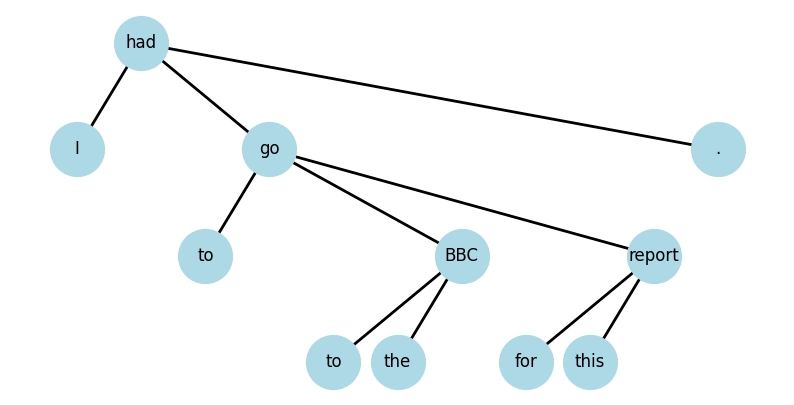

In [150]:
def graph_from_distance_matrix(mat, ids, root_dist, forms, ax=None, node_size = 1500, font_size = 12, width = 2, plot = True):

    # Compute MST using Kruskal’s algorithm
    G = nx.from_numpy_array(mat)
    mst = nx.minimum_spanning_tree(G, algorithm="kruskal")
    # get adjacency matrix as np array
    adj_matrix = nx.to_numpy_array(mst)
    # Prepare node positions: x=ids, y=root_dist, to get a readable plot
    pos = {i: (id, len(root_dist) - root_dist[idx]) for idx, (i, id) in enumerate(zip(range(len(ids)), ids))}

    if plot:
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 6))
        nx.draw(
            mst,
            pos=pos,
            ax=ax,
            with_labels=True,
            labels={i: forms[i] for i in range(len(forms))},
            node_color='lightblue',
            edge_color='black',
            node_size=node_size,
            font_size=font_size,
            width=width,
        )
        ax.set_xlabel("ids")
        ax.set_ylabel("root_dist")

    return adj_matrix, ax

fig, axs = plt.subplots(1, 1, figsize=(10, 5))
graph_from_distance_matrix(mat, ids, root_dist, forms, ax=axs)
plt.show()

Lets do this for some more sentences:

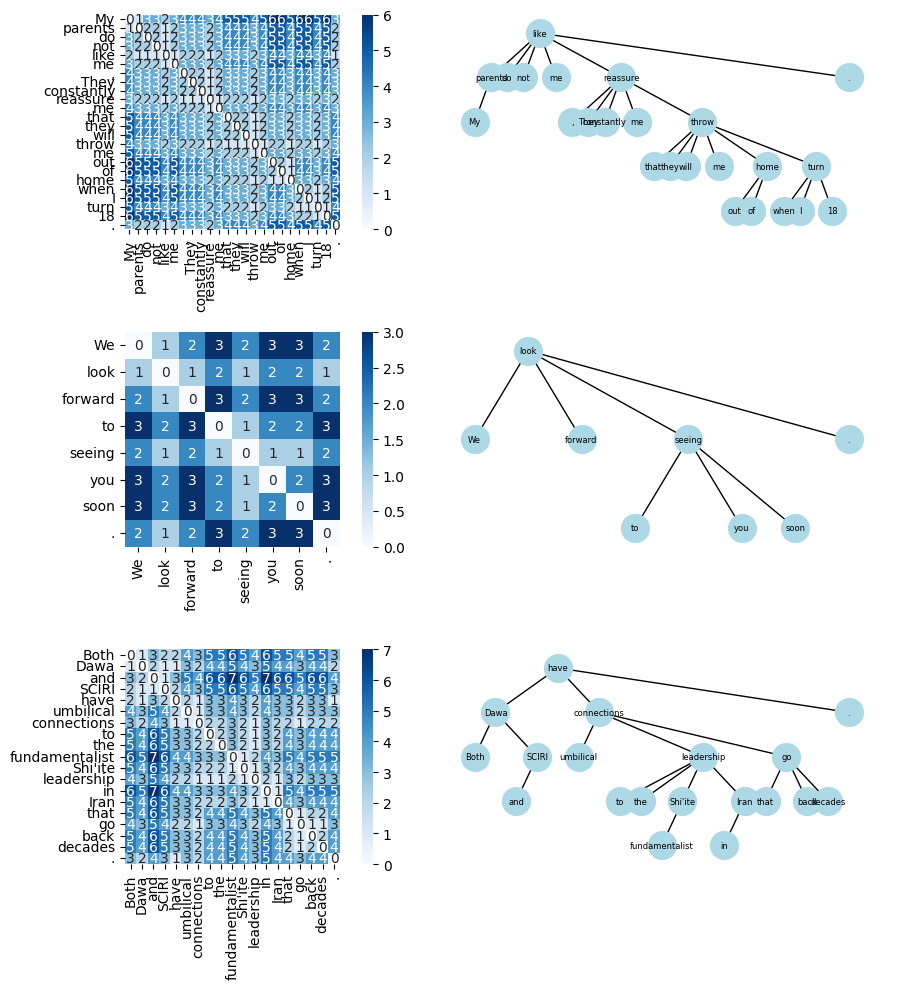

In [151]:
num_sentences = 3
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

np.random.seed(2) # note that the sentences can be quite long, if the seed is changed
for i, id in enumerate(np.random.randint(0, len(sentences_train), size = num_sentences)):
    mat, ids, root_dist, forms = distance_matrix_from_sentence(sentences_train[id])
    sns.heatmap(mat, xticklabels=forms, yticklabels=forms, cmap="Blues", annot=True, ax = axs[i, 0], square =True)
    graph_from_distance_matrix(mat, ids, root_dist, forms, ax=axs[i, 1], node_size = 400, font_size = 6, width = 1)
plt.tight_layout()

## Research Question

We evaluate whether parsing trees are embedded in the hidden layer of a large language model. However, se cannot decode the syntactic dependencies by looking at the raw embeddings, since these will also encode additional information, such as semantics or task relevant aspects for next-token prediction. Therefore, we will aim to extract the syntactic content using a **structural probe**, which maps the embeddings into a new, lower-dimensional structure (see figure below)

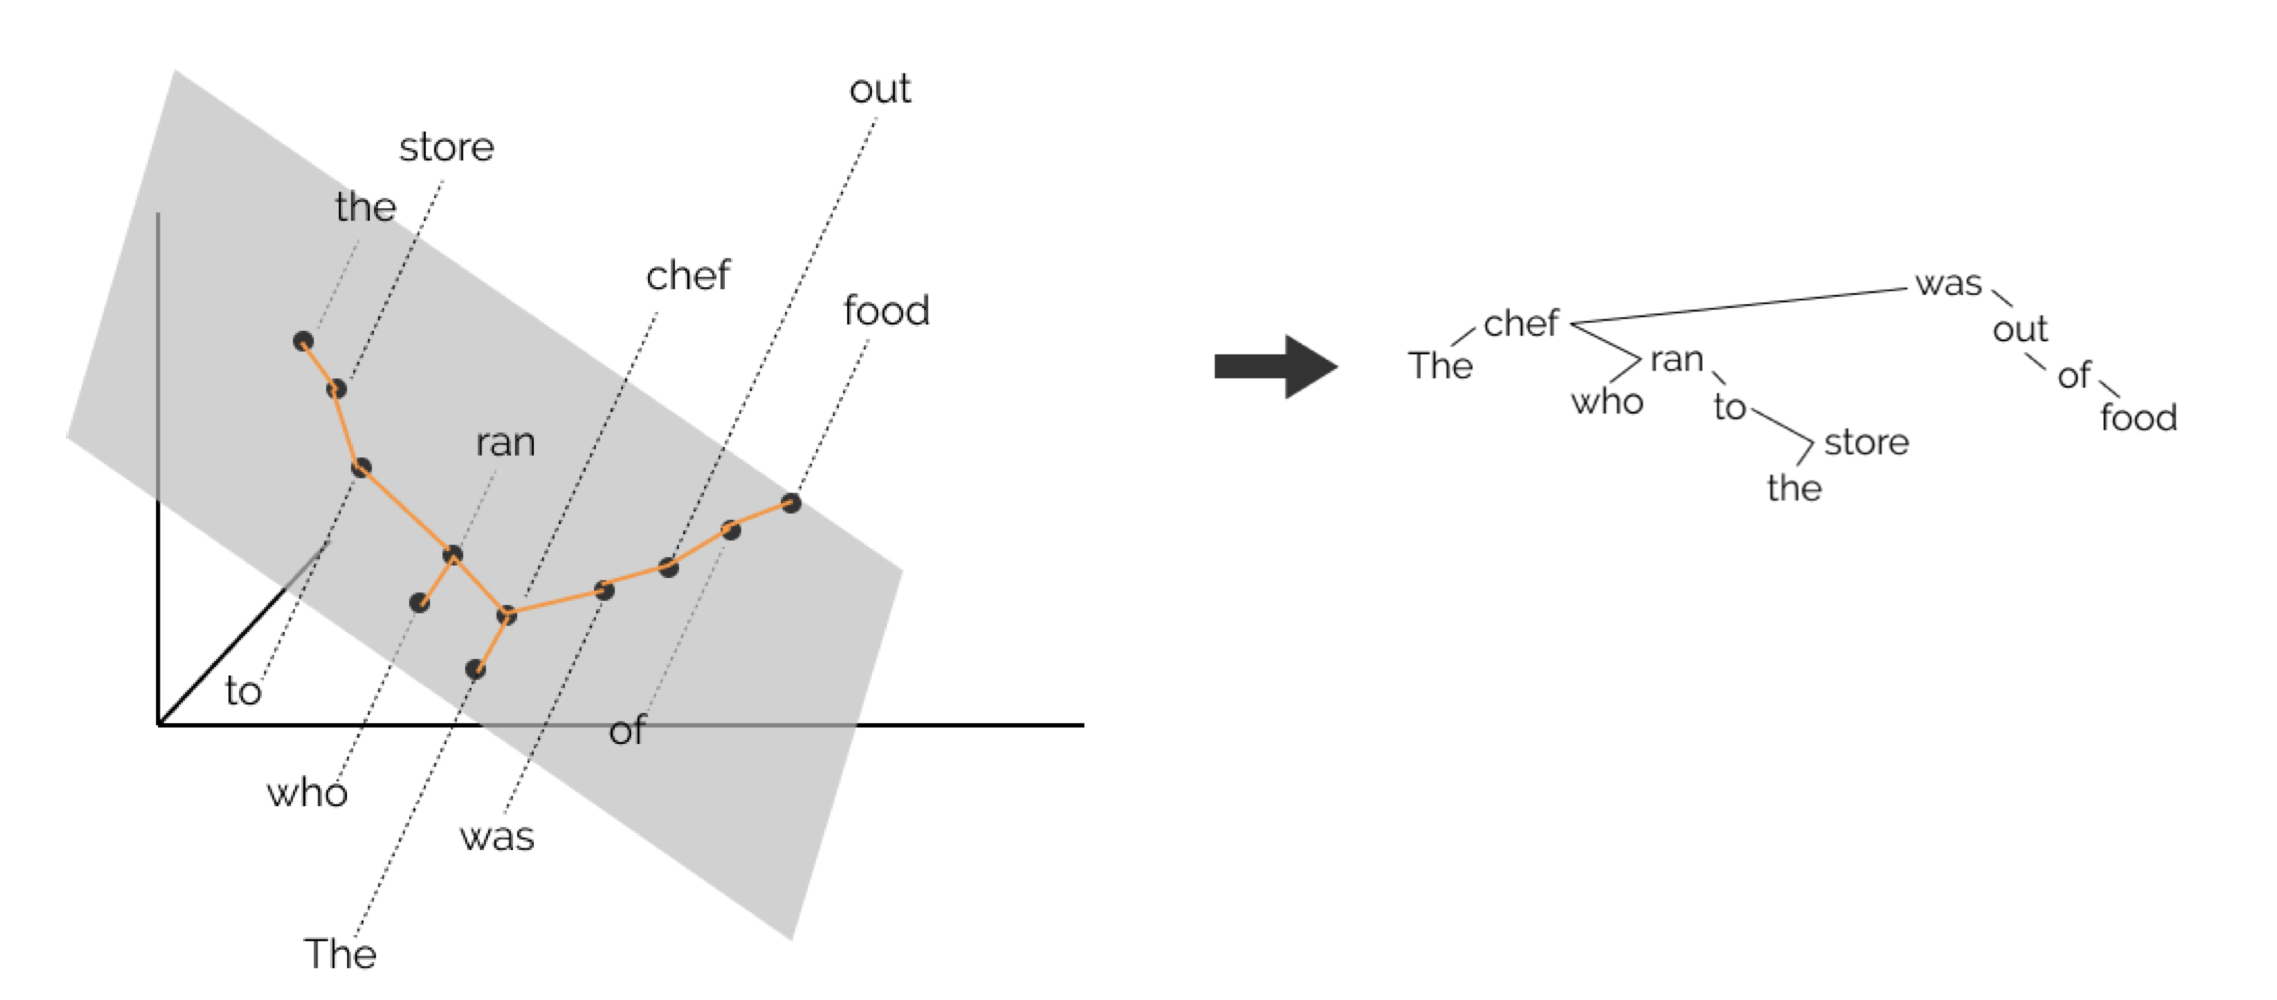

In [109]:
# from Hewitt and Manning (2019)
image_path = "images/probe_scheme.jpeg"
display(Image(filename=image_path, width=600, height=400))

The probe transforms the individual word embeddings (from the LLM) for each token in the sentence. Specifically, it projects each embedding into a lower-dimensional space (of a pre-determined size) using the learned probe matrix. Then, it computes pairwise distances between these projected embeddings to form the predicted syntactic distance matrix. Therefore, the only "deep" learning we do, is determining that projection matrices weights.

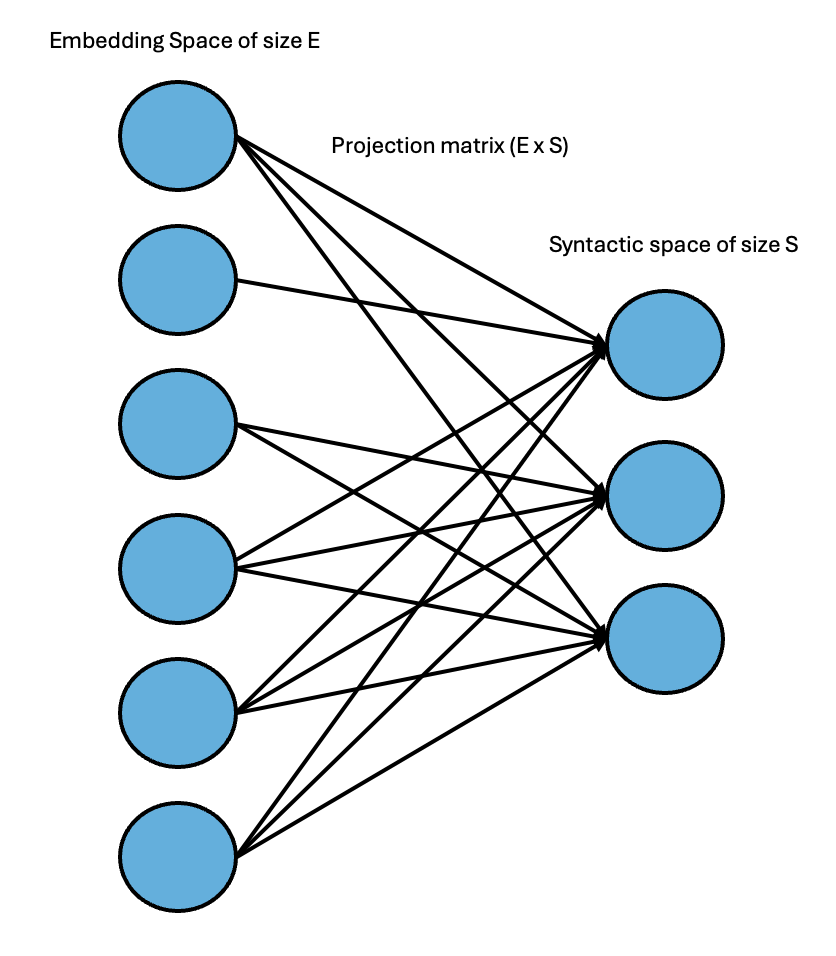

In [110]:
# add figure showing probe architecture
image_path = "images/mlp_scheme.png"
display(Image(filename=image_path, width=300, height=200))

Our projects unique contributions are...

## Implement Structural Probe

### Define functions to get embeddings and matrices

For the ground truth matrices, we just apply it to all our sentences in the for-loop. For the LLM-emeddings we need to ensure that the models tokenizer matches our annotations in the dataset. We do this by averaging embeddings of tokens that are part of the same word.

In [152]:
def get_matrices(sentences):
    """function to get distance matrices for a list of sentences"""
    matrices = []
    for sent in sentences:
        mat, _, _, _ = distance_matrix_from_sentence(sent)
        matrices.append(mat)
    return matrices
matrices_train = get_matrices(sentences_train)

def combine_token_embeddings(text, word_list, model, layer_name):
    """
    Given a sentence string, a list of words (from UD), and a model,
    returns a tensor of shape (num_words, hidden_dim) where each row
    is the combined embedding for a word (by averaging over subword tokens).
    """
    # Tokenize with offsets
    tokenizer = model.tokenizer
    encoding = tokenizer(text, return_offsets_mapping=True, return_tensors='pt')
    offsets = encoding['offset_mapping'][0].tolist()
    tokens = tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])
    # Get model activations
    _, cache = model.run_with_cache([text])
    activations = cache[layer_name][0]  # shape: (num_tokens, hidden_dim)
    # Map words to token indices
    word_spans = []
    start = 0
    for word in word_list:
        end = start + len(word)
        word_spans.append((start, end))
        start = end + 1  # +1 for space
    # For each word, find token indices whose offsets overlap with the word span
    word_embeddings = []
    for span in word_spans:
        indices = [i for i, (s, e) in enumerate(offsets) if not (e <= span[0] or s >= span[1])]
        if indices:
            emb = activations[indices].mean(dim=0)
        else:
            emb = torch.zeros(activations.shape[1], device=activations.device)
        word_embeddings.append(emb)
    return torch.stack(word_embeddings)

In [154]:
class SyntaxProbeDataset(Dataset):
    def __init__(self, sentences, model_name, layer_name):
        self.sentences = []
        self.activations = []
        self.matrices = []
        model = transformer_lens.HookedTransformer.from_pretrained(model_name)
        for sentence in tqdm(sentences, desc="Processing sentences"):
            text = sentence.metadata["text"]
            activations = combine_token_embeddings(text, [tok["form"] for tok in sentence], model, layer_name)
            activation = activations.cpu().numpy()
            mat, _, _, _ = distance_matrix_from_sentence(sentence)
                
            if activation.shape[0] > 0 and mat.shape[0] > 0:
                self.sentences.append(sentence)
                self.activations.append(activation)
                self.matrices.append(mat)

    def __len__(self):
        return len(self.sentences)
    def __getitem__(self, idx):
        return self.activations[idx], self.matrices[idx]
    
def custom_collate_fn(batch):
    """Function to collate a batch of (activation, matrix) tuples by padding them to the same length."""
    # batch: list of (activation, matrix) tuples
    activations, matrices = zip(*batch)
    batch_size = len(activations)
    seq_lens = [a.shape[0] for a in activations]
    max_len = max(seq_lens)
    hidden_dim = activations[0].shape[1]

    # Pad activations
    padded_activations = np.zeros((batch_size, max_len, hidden_dim), dtype=np.float32)
    for i, act in enumerate(activations):
        padded_activations[i, :act.shape[0], :] = act

    # Pad matrices
    padded_matrices = np.full((batch_size, max_len, max_len), fill_value=-1, dtype=np.float32)
    for i, mat in enumerate(matrices):
        l = mat.shape[0]
        padded_matrices[i, :l, :l] = mat

    # Convert to torch tensors
    padded_activations = torch.tensor(padded_activations)
    padded_matrices = torch.tensor(padded_matrices)
    lengths = torch.tensor(seq_lens)

    return padded_activations, padded_matrices, lengths, None

### Load Data

### Decide on minimum amount of tokens per sentence ###

In [156]:
def n_int_tokens(sentence):
    return sum(1 for tok in sentence if isinstance(tok["id"], int))

no_edge_train = [i for i, s in enumerate(sentences_train) if n_int_tokens(s) < 2]
no_edge_test  = [i for i, s in enumerate(sentences_test)  if n_int_tokens(s) < 2]

print("Train: len<2 tokens (no edges):", len(no_edge_train), "/", len(sentences_train))
print("Test : len<2 tokens (no edges):", len(no_edge_test),  "/", len(sentences_test))

Train: len<2 tokens (no edges): 429 / 12279
Test : len<2 tokens (no edges): 132 / 2004


### Original code for loading data ###

In [ ]:
sentences_train, sentences_test = get_data()
# create val split
np.random.seed(42)
val_idx = np.random.randint(0, len(sentences_train), size = int(0.1 * len(sentences_train)))
sentences_val = [sentences_train[i] for i in val_idx]
sentences_train = [sentences_train[i] for i in range(len(sentences_train)) if i not in val_idx]

len(sentences_train), len(sentences_val), len(sentences_test)

(11112, 1227, 2004)

### Possible new code ensuring exclusion of sentences with less than 5 tokens ###

In [157]:
# 1) Load raw data
sentences_train, sentences_test = get_data()

# 2) Filter AFTER loading (keep only sentences with >= 5 integer-ID tokens)
min_tokens = 2
sentences_train_edges = [s for s in sentences_train if n_int_tokens(s) >= min_tokens]
sentences_test_edges  = [s for s in sentences_test  if n_int_tokens(s) >= min_tokens]

print("Train:", len(sentences_train), "→", len(sentences_train_edges))
print("Test :", len(sentences_test),  "→", len(sentences_test_edges))

Train: 12279 → 11850
Test : 2004 → 1872


In [158]:
# create val split (after filtering!)
np.random.seed(289)

n = len(sentences_train_edges)
val_size = int(0.1 * n)

# IMPORTANT: choose without replacement (no duplicates)
val_idx = np.random.choice(n, size=val_size, replace=False)

sentences_val = [sentences_train_edges[i] for i in val_idx]
val_idx_set = set(val_idx)
sentences_train_edges = [sentences_train_edges[i] for i in range(n) if i not in val_idx_set]

len(sentences_train_edges), len(sentences_val), len(sentences_test_edges)

(10665, 1185, 1872)

### Implement Probes and Regimen

The code for the probes is adpated from https://github.com/john-hewitt/structural-probes

In [159]:
class Probe(nn.Module):
  pass

class TwoWordPSDProbe(Probe):
  """ Computes squared L2 distance after projection by a matrix.

  For a batch of sentences, computes all n^2 pairs of distances
  for each sentence in the batch.
  """
  def __init__(self, args):
    print('Constructing TwoWordPSDProbe')
    super(TwoWordPSDProbe, self).__init__()
    self.args = args
    self.probe_rank = args['probe']['maximum_rank']
    self.model_dim = args['model']['hidden_dim']

    # Initialize projection matrix
    self.proj = nn.Parameter(data = torch.zeros(self.model_dim, self.probe_rank))
    nn.init.uniform_(self.proj, -0.05, 0.05)
    self.to(args['device'])

  def forward(self, batch):
    """ Computes all n^2 pairs of distances after projection
    for each sentence in a batch.

    Note that due to padding, some distances will be non-zero for pads.
    Computes (B(h_i-h_j))^T(B(h_i-h_j)) for all i,j

    Args:
      batch: a batch of word representations of the shape
        (batch_size, max_seq_len, representation_dim)
    Returns:
      A tensor of distances of shape (batch_size, max_seq_len, max_seq_len)
    """
    batch = batch.to(self.proj.device) # added

    transformed = torch.matmul(batch, self.proj)
    batchlen, seqlen, rank = transformed.size()
    transformed = transformed.unsqueeze(2)
    transformed = transformed.expand(-1, -1, seqlen, -1)
    transposed = transformed.transpose(1,2).to(self.proj.device)
    diffs = transformed - transposed
    squared_diffs = diffs.pow(2).to(self.proj.device)
    squared_distances = torch.sum(squared_diffs, -1)
    return squared_distances

In [160]:
class L1DistanceLoss(nn.Module):
  """Custom L1 loss for distance matrices."""
  def __init__(self, args):
    super(L1DistanceLoss, self).__init__()
    self.args = args
    self.word_pair_dims = (1,2)

  def forward(self, predictions, label_batch, length_batch):
    """ Computes L1 loss on distance matrices.

    Ignores all entries where label_batch=-1
    Normalizes first within sentences (by dividing by the square of the sentence length)
    and then across the batch.

    Args:
      predictions: A pytorch batch of predicted distances
      label_batch: A pytorch batch of true distances
      length_batch: A pytorch batch of sentence lengths

    Returns:
      A tuple of:
        batch_loss: average loss in the batch
        total_sents: number of sentences in the batch
    """
    device = predictions.device
    label_batch = label_batch.to(device)
    length_batch = length_batch.to(device)

    labels_1s = (label_batch != -1).float()
    predictions_masked = predictions * labels_1s
    labels_masked = label_batch * labels_1s
    total_sents = torch.sum((length_batch != 0)).float()
    squared_lengths = length_batch.pow(2).float()
    if total_sents > 0:
      loss_per_sent = torch.sum(torch.abs(predictions_masked - labels_masked), dim=self.word_pair_dims)
      normalized_loss_per_sent = loss_per_sent / squared_lengths
      batch_loss = torch.sum(normalized_loss_per_sent) / total_sents
    else:
      batch_loss = torch.tensor(0.0, device=self.args['device'])
    return batch_loss, total_sents


In [161]:
"""Classes for training and running inference on probes."""

class ProbeRegimen:
  """Basic regimen for training and running inference on probes.
  
  Tutorial help from:
  https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

  Attributes:
    optimizer: the optimizer used to train the probe
    scheduler: the scheduler used to set the optimizer base learning rate
  """

  def __init__(self, args):
    self.args = args
    self.max_epochs = args['probe_training']['epochs']
    self.params_path = os.path.join(args['reporting']['root'], args['probe']['params_path'])

  def set_optimizer(self, probe):
    """Sets the optimizer and scheduler for the training regimen.
  
    Args:
      probe: the probe PyTorch model the optimizer should act on.
    """
    self.optimizer = optim.Adam(probe.parameters(), lr=0.001)
    self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1,patience=0)

  def train_until_convergence(self, probe, model, loss, train_dataset, dev_dataset):
    """ Trains a probe until a convergence criterion is met.

    Trains until loss on the development set does not improve by more than epsilon
    for 5 straight epochs.

    Writes parameters of the probe to disk, at the location specified by config.

    Args:
      probe: An instance of probe.Probe, transforming model outputs to predictions
      model: An instance of model.Model, transforming inputs to word reprs
      loss: An instance of loss.Loss, computing loss between predictions and labels
      train_dataset: a torch.DataLoader object for iterating through training data
      dev_dataset: a torch.DataLoader object for iterating through dev data
    """
    self.set_optimizer(probe)
    min_dev_loss = sys.maxsize
    min_dev_loss_epoch = -1

    self.train_losses = []
    self.val_losses = []
    
    for epoch_index in tqdm(range(self.max_epochs), desc='[training]'):
      epoch_train_loss = 0
      epoch_dev_loss = 0
      epoch_train_epoch_count = 0
      epoch_dev_epoch_count = 0
      epoch_train_loss_count = 0
      epoch_dev_loss_count = 0
      for batch in tqdm(train_dataset, desc='[training batch]'):
        probe.train()
        self.optimizer.zero_grad()
        observation_batch, label_batch, length_batch, _ = batch
        word_representations = model(observation_batch)
        predictions = probe(word_representations)
        batch_loss, count = loss(predictions, label_batch, length_batch)
        batch_loss.backward()
        epoch_train_loss += batch_loss.detach().cpu().numpy()*count.detach().cpu().numpy()
        epoch_train_epoch_count += 1
        epoch_train_loss_count += count.detach().cpu().numpy()
        self.optimizer.step()
      for batch in tqdm(dev_dataset, desc='[dev batch]'):
        self.optimizer.zero_grad()
        probe.eval()
        observation_batch, label_batch, length_batch, _ = batch
        word_representations = model(observation_batch)
        predictions = probe(word_representations)
        batch_loss, count = loss(predictions, label_batch, length_batch)
        epoch_dev_loss += batch_loss.detach().cpu().numpy()*count.detach().cpu().numpy()
        epoch_dev_loss_count += count.detach().cpu().numpy()
        epoch_dev_epoch_count += 1


      # Compute average losses and store them
      avg_train_loss = epoch_train_loss / epoch_train_loss_count
      avg_dev_loss = epoch_dev_loss / epoch_dev_loss_count
      self.train_losses.append(avg_train_loss)
      self.val_losses.append(avg_dev_loss)
        
      self.scheduler.step(epoch_dev_loss)
      tqdm.write('[epoch {}] Train loss: {}, Dev loss: {}'.format(epoch_index, epoch_train_loss/epoch_train_loss_count, epoch_dev_loss/epoch_dev_loss_count))
      if epoch_dev_loss / epoch_dev_loss_count < min_dev_loss - 0.0001:
        torch.save(probe.state_dict(), self.params_path)
        min_dev_loss = epoch_dev_loss / epoch_dev_loss_count
        min_dev_loss_epoch = epoch_index
        tqdm.write('Saving probe parameters')
      elif min_dev_loss_epoch < epoch_index - 4:
        tqdm.write('Early stopping')
        break

  def predict(self, probe, model, dataset):
    """ Runs probe to compute predictions on a dataset.

    Args:
      probe: An instance of probe.Probe, transforming model outputs to predictions
      model: An instance of model.Model, transforming inputs to word reprs
      dataset: A pytorch.DataLoader object 

    Returns:
      A list of predictions for each batch in the batches yielded by the dataset
    """
    probe.eval()
    predictions_by_batch = []
    for batch in tqdm(dataset, desc='[predicting]'):
      observation_batch, label_batch, length_batch, _ = batch
      word_representations = model(observation_batch)
      predictions = probe(word_representations)
      predictions_by_batch.append(predictions.detach().cpu().numpy())
    return predictions_by_batch

### Train Model

In [162]:
# this cell may take around 5-10 minutes to run, since all activations are being extracted and transformed to match data sequentially
# rank of probe and epoch was determined via validation set performance

layer = 'blocks.8.hook_resid_post'

args = {
    'probe': {'maximum_rank': 64, 'params_path': f'probe_params/{layer}_probe_params.pt'},
    'model': {'hidden_dim': 768},
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'probe_training': {'epochs': 20},
    'reporting': {'root': './'}
}
probe = TwoWordPSDProbe(args)
loss_fn = L1DistanceLoss(args)
regimen = ProbeRegimen(args)

dataset = SyntaxProbeDataset(sentences_train_edges, 'gpt2-small', layer)
dataloader = DataLoader(dataset, batch_size=32, collate_fn=custom_collate_fn)

val_dataset = SyntaxProbeDataset(sentences_val, 'gpt2-small', layer)
val_dataloader = DataLoader(val_dataset, batch_size=32, collate_fn=custom_collate_fn)

# we use this as the original code assumes feature extraction inside the regimen, while we do so with our custom functions in advance
class IdentityModel(nn.Module):
    def forward(self, x):
        return x
model = IdentityModel()

Constructing TwoWordPSDProbe
Loaded pretrained model gpt2-small into HookedTransformer


Processing sentences: 100%|██████████| 10665/10665 [13:47<00:00, 12.90it/s] 


Loaded pretrained model gpt2-small into HookedTransformer


Processing sentences: 100%|██████████| 1185/1185 [01:32<00:00, 12.76it/s]


In [163]:
# model training may also take about 10 minutes
regimen.train_until_convergence(
    probe=probe,
    model=model,
    loss=loss_fn,
    train_dataset=dataloader,
    dev_dataset=val_dataloader
)

[training]:   5%|▌         | 1/20 [00:13<04:16, 13.48s/it]

[epoch 0] Train loss: 1079.9810235089224, Dev loss: 93.62179105734523
Saving probe parameters


[training]:  10%|█         | 2/20 [00:18<02:35,  8.64s/it]

[epoch 1] Train loss: 57.435741360535154, Dev loss: 32.580447738583075
Saving probe parameters


[training]:  15%|█▌        | 3/20 [00:23<01:56,  6.87s/it]

[epoch 2] Train loss: 20.921713721824823, Dev loss: 12.355268766507821
Saving probe parameters


[training]:  20%|██        | 4/20 [00:28<01:38,  6.16s/it]

[epoch 3] Train loss: 8.06462081000663, Dev loss: 4.4779613168933725
Saving probe parameters


[training]:  25%|██▌       | 5/20 [00:33<01:26,  5.76s/it]

[epoch 4] Train loss: 2.8613746308632093, Dev loss: 1.913357722608349
Saving probe parameters


[training]:  30%|███       | 6/20 [00:38<01:16,  5.47s/it]

[epoch 5] Train loss: 1.7200994756263128, Dev loss: 1.328952213178707
Saving probe parameters


[training]:  35%|███▌      | 7/20 [00:43<01:11,  5.47s/it]

[epoch 6] Train loss: 1.200216741870392, Dev loss: 1.0284917996402532
Saving probe parameters


[training]:  40%|████      | 8/20 [00:49<01:05,  5.47s/it]

[epoch 7] Train loss: 1.3235343587940644, Dev loss: 1.1961275321018847


[training]:  45%|████▌     | 9/20 [00:54<00:59,  5.41s/it]

[epoch 8] Train loss: 0.8904694613972238, Dev loss: 0.9270067891994106
Saving probe parameters


[training]:  50%|█████     | 10/20 [01:00<00:53,  5.39s/it]

[epoch 9] Train loss: 0.8752066883636203, Dev loss: 0.9125842940455248
Saving probe parameters


[training]:  55%|█████▌    | 11/20 [01:05<00:48,  5.39s/it]

[epoch 10] Train loss: 0.8642473877174889, Dev loss: 0.9172998779433689


[training]:  60%|██████    | 12/20 [01:10<00:43,  5.41s/it]

[epoch 11] Train loss: 0.8495818059879237, Dev loss: 0.8955542946666605
Saving probe parameters


[training]:  65%|██████▌   | 13/20 [01:15<00:37,  5.29s/it]

[epoch 12] Train loss: 0.8475729392830106, Dev loss: 0.8941128732785897
Saving probe parameters


[training]:  70%|███████   | 14/20 [01:21<00:31,  5.26s/it]

[epoch 13] Train loss: 0.8459475956776865, Dev loss: 0.8925099286349011
Saving probe parameters


[training]:  75%|███████▌  | 15/20 [01:26<00:25,  5.18s/it]

[epoch 14] Train loss: 0.8446948368449866, Dev loss: 0.8912953076986321
Saving probe parameters


[training]:  80%|████████  | 16/20 [01:31<00:20,  5.14s/it]

[epoch 15] Train loss: 0.8430718459939934, Dev loss: 0.8894840912476873
Saving probe parameters


[training]:  85%|████████▌ | 17/20 [01:36<00:15,  5.16s/it]

[epoch 16] Train loss: 0.8412817325940782, Dev loss: 0.8891103996003228
Saving probe parameters


[training]:  90%|█████████ | 18/20 [01:41<00:10,  5.09s/it]

[epoch 17] Train loss: 0.8391269823334556, Dev loss: 0.8874152042694735
Saving probe parameters


[training]:  95%|█████████▌| 19/20 [01:46<00:05,  5.10s/it]

[epoch 18] Train loss: 0.8368505573585678, Dev loss: 0.8838347736793228
Saving probe parameters


[training]: 100%|██████████| 20/20 [01:51<00:00,  5.57s/it]

[epoch 19] Train loss: 0.835240076049862, Dev loss: 0.8822229341112612
Saving probe parameters


## Model Evaluation

First, we take a look at the loss curves. Loss is decreasing over epochs which means that at least something is being learned successfully. Moreover, there os no evidence of overfitting.

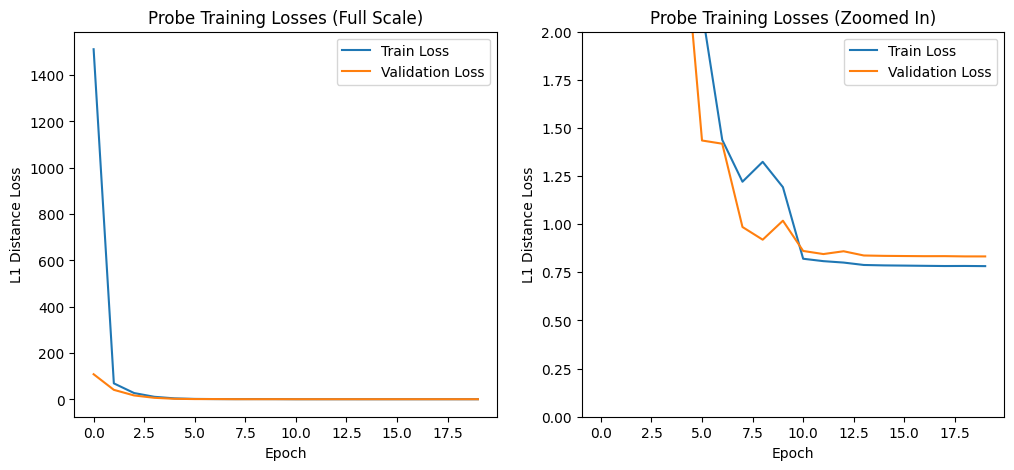

In [122]:
# loss function plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(regimen.train_losses, label='Train Loss')
ax[0].plot(regimen.val_losses, label='Validation Loss')
ax[0].set_title('Probe Training Losses (Full Scale)')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('L1 Distance Loss')
ax[0].legend()

ax[1].plot(regimen.train_losses, label='Train Loss')
ax[1].plot(regimen.val_losses, label='Validation Loss')
ax[1].set_title('Probe Training Losses (Zoomed In)')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('L1 Distance Loss')
ax[1].set_ylim(0, 2)
ax[1].legend()

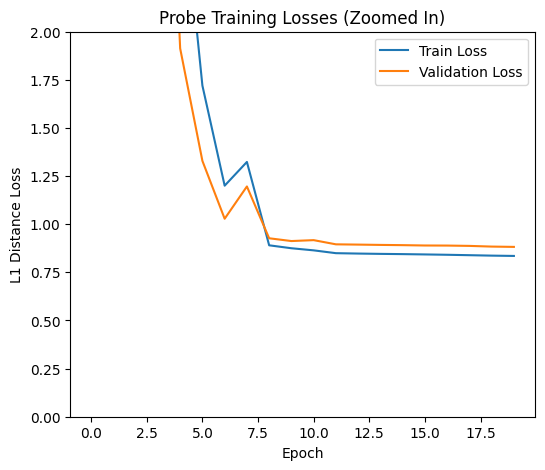

In [164]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.plot(regimen.train_losses, label='Train Loss')
ax.plot(regimen.val_losses, label='Validation Loss')

ax.set_title('Probe Training Losses (Zoomed In)')
ax.set_xlabel('Epoch')
ax.set_ylabel('L1 Distance Loss')
ax.set_ylim(0, 2)
ax.legend()

plt.show()

Loss curves are nice, but not very interpretable. So next we apply our model on some previously unseen sentences (the test set)

In [165]:
# Prepare new sentences as a SyntaxProbeDataset and DataLoader
novel_sentences = sentences_test_edges
novel_dataset = SyntaxProbeDataset(novel_sentences, 'gpt2-small', layer)
novel_dataloader = DataLoader(novel_dataset, batch_size = 100, collate_fn=custom_collate_fn)

# Make predictions
predictions = regimen.predict(probe, model, novel_dataloader)

Loaded pretrained model gpt2-small into HookedTransformer


[predicting]: 100%|██████████| 19/19 [00:00<00:00, 25.60it/s]


Neither did Cheney, Rumsfeld, or Wolfowitz.


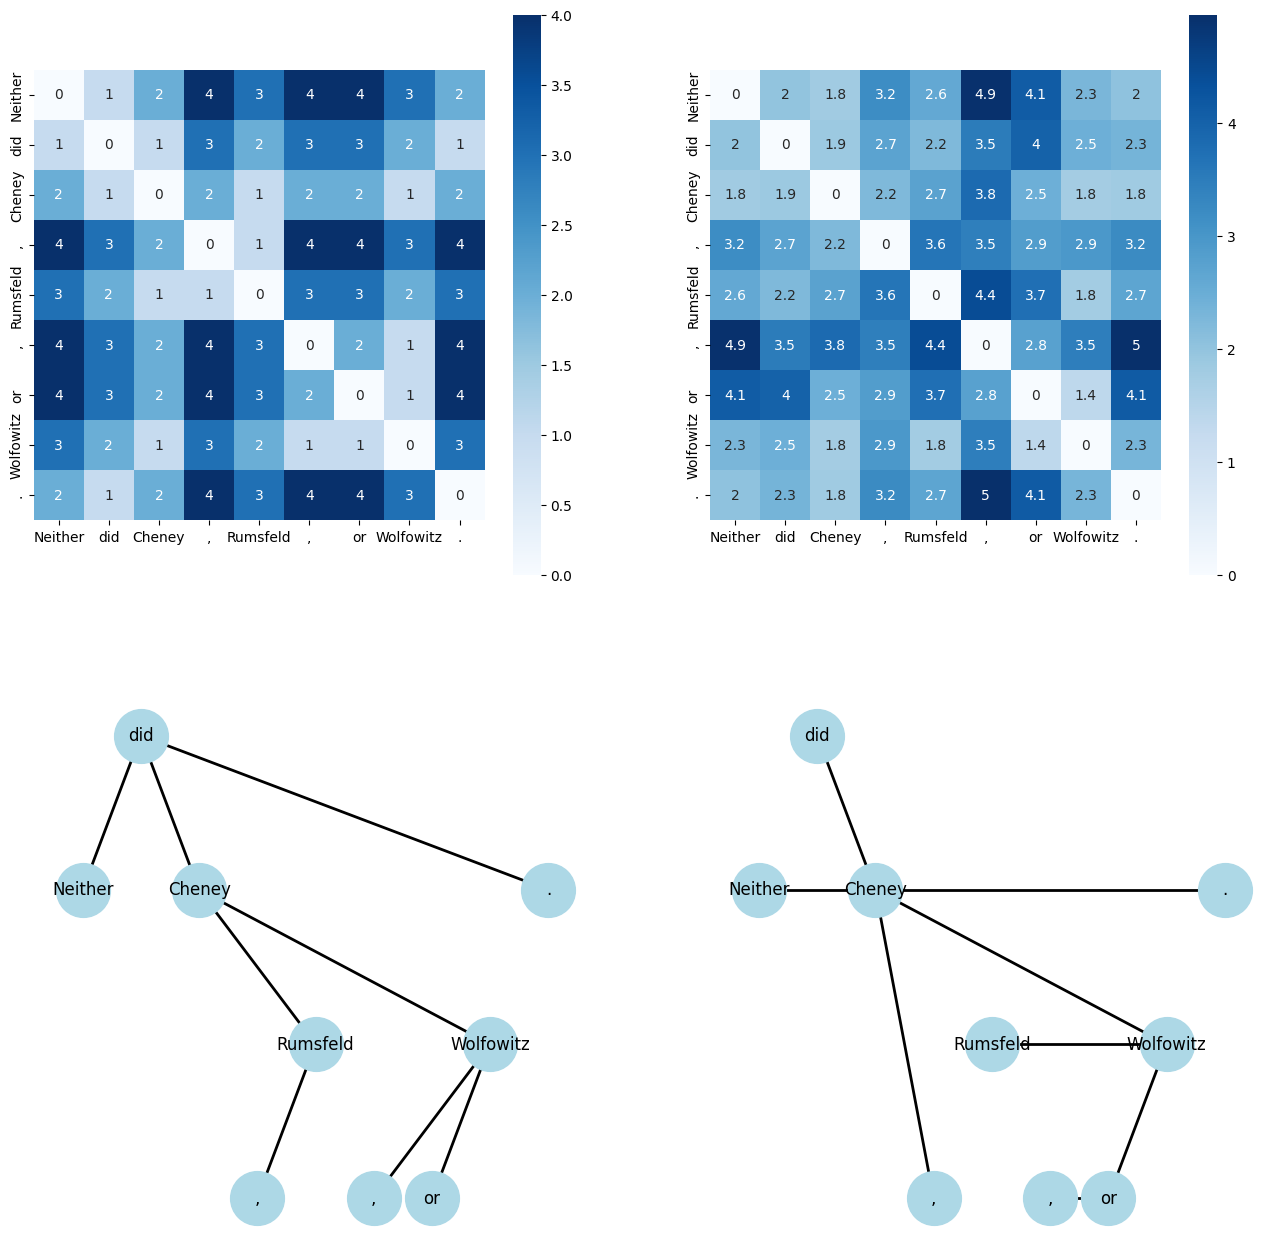

In [166]:
# plot an example of true vs.predicted sentence
sentence_idx = 192
batch_size = 100
batch_id = sentence_idx // batch_size
idx_in_batch = sentence_idx % batch_size

mat, ids, root_dist, forms = distance_matrix_from_sentence(sentences_test_edges[sentence_idx])
sentence = novel_sentences[sentence_idx]
print(sentence.metadata["text"])

fig, ax = plt.subplots(2, 2, figsize=(16, 16))
# true mat
sns.heatmap(mat, cmap = "Blues", square = True, annot = True, xticklabels=forms, yticklabels=forms, ax = ax[0, 0])
# pred mat
sns.heatmap(predictions[batch_id][idx_in_batch][:len(sentence), :len(sentence)],square=True,
            cmap = "Blues", annot = True, xticklabels=forms, yticklabels=forms, 
            ax = ax[0, 1])

graph_from_distance_matrix(mat, ids, root_dist, forms, ax=ax[1, 0])
graph_from_distance_matrix(predictions[batch_id][idx_in_batch][:len(sentence), :len(sentence)], ids, root_dist, forms, ax=ax[1, 1])

plt.show()

In [167]:
def eval_parse_trees(test_sentences, predictions, batch_size):
    total_TP = total_TN = total_FP = total_FN = 0
    for sentence_idx, sentence in enumerate(test_sentences):
        batch_id = sentence_idx // batch_size
        idx_in_batch = sentence_idx % batch_size

        mat, ids, root_dist, forms = distance_matrix_from_sentence(sentence)
        n = mat.shape[0]
        m1, _ = graph_from_distance_matrix(mat, ids, root_dist, forms, plot = False)
        pred_mat = predictions[batch_id][idx_in_batch]
        # ensure square and same size
        pred_mat = pred_mat[:n, :n]

        m2, _ = graph_from_distance_matrix(pred_mat, ids, root_dist, forms, plot = False)

        upper_m1 = np.triu(m1, k=1)
        upper_m2 = np.triu(m2, k=1)

        TP = np.count_nonzero((upper_m1 != 0) & (upper_m2 != 0))
        TN = np.count_nonzero((upper_m1 == 0) & (upper_m2 == 0))
        FP = np.count_nonzero((upper_m1 == 0) & (upper_m2 != 0))
        FN = np.count_nonzero((upper_m1 != 0) & (upper_m2 == 0))

        total_TP += TP
        total_TN += TN
        total_FP += FP
        total_FN += FN
    
    accuracy = (total_TP + total_TN) / (total_TP + total_TN + total_FP + total_FN)
    print(f"Overall Accuracy: {accuracy:.4f}")
    sensitivity = total_TP / (total_TP + total_FN) if (total_TP + total_FN) > 0 else 0 # aka recall
    specificity = total_TN / (total_TN + total_FP) if (total_TN + total_FP) > 0 else 0 


    print(f"Total True Positives: {total_TP}, Total True Negatives: {total_TN}, Total False Positives: {total_FP}, Total False Negatives: {total_FN}")
    print(f"Accuracy: {accuracy:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")
    return accuracy, sensitivity, specificity

In [168]:
eval_parse_trees(novel_sentences, predictions, batch_size=100)

Overall Accuracy: 0.9474
Total True Positives: 8680, Total True Negatives: 486221, Total False Positives: 13731, Total False Negatives: 13731
Accuracy: 0.9474, Sensitivity: 0.3873, Specificity: 0.9725


(0.9474273637298201, 0.3873098032216322, 0.9725353633948859)

### Macro-averages ###

In [171]:
import numpy as np

def eval_parse_trees_macro(test_sentences, predictions, batch_size):
    acc_list, sens_list, spec_list = [], [], []

    for sentence_idx, sentence in enumerate(test_sentences):
        batch_id = sentence_idx // batch_size
        idx_in_batch = sentence_idx % batch_size

        mat, ids, root_dist, forms = distance_matrix_from_sentence(sentence)
        n = mat.shape[0]
        m1, _ = graph_from_distance_matrix(mat, ids, root_dist, forms, plot=False)

        pred_mat = predictions[batch_id][idx_in_batch][:n, :n]
        m2, _ = graph_from_distance_matrix(pred_mat, ids, root_dist, forms, plot=False)

        upper_m1 = np.triu(m1, k=1)
        upper_m2 = np.triu(m2, k=1)

        TP = np.count_nonzero((upper_m1 != 0) & (upper_m2 != 0))
        TN = np.count_nonzero((upper_m1 == 0) & (upper_m2 == 0))
        FP = np.count_nonzero((upper_m1 == 0) & (upper_m2 != 0))
        FN = np.count_nonzero((upper_m1 != 0) & (upper_m2 == 0))

        denom = TP + TN + FP + FN
        if denom == 0:
            # happens for n < 2 (no pairs); skip this sentence
            continue

        acc = (TP + TN) / denom
        sens = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        spec = TN / (TN + FP) if (TN + FP) > 0 else 0.0

        acc_list.append(acc)
        sens_list.append(sens)
        spec_list.append(spec)

    macro_acc = float(np.mean(acc_list)) if acc_list else 0.0
    macro_sens = float(np.mean(sens_list)) if sens_list else 0.0
    macro_spec = float(np.mean(spec_list)) if spec_list else 0.0

    print(f"Macro Accuracy: {macro_acc:.4f}")
    print(f"Macro Sensitivity: {macro_sens:.4f}")
    print(f"Macro Specificity: {macro_spec:.4f}")
    print(f"Used sentences: {len(acc_list)} / {len(test_sentences)}")

    return macro_acc, macro_sens, macro_spec, acc_list, sens_list, spec_list

In [177]:
macro_acc, macro_sens, macro_spec, acc_list, sens_list, spec_list = eval_parse_trees_macro(
    test_sentences=novel_sentences,
    predictions=predictions,
    batch_size=100
)

Macro Accuracy: 0.9130
Macro Sensitivity: 0.4926
Macro Specificity: 0.9507
Used sentences: 1872 / 1872


In [169]:
def eval_parse_trees_by_depth(test_sentences, predictions, batch_size):
    total_TP = total_TN = total_FP = total_FN = 0

    df = pd.DataFrame(columns=['TP', 'TN', 'FP', 'FN'])

    for sentence_idx, sentence in enumerate(test_sentences):
        batch_id = sentence_idx // batch_size
        idx_in_batch = sentence_idx % batch_size

        mat, ids, root_dist, forms = distance_matrix_from_sentence(sentence)
        n = mat.shape[0]
        m1, _ = graph_from_distance_matrix(mat, ids, root_dist, forms, plot = False)

        pred_mat = predictions[batch_id][idx_in_batch]
        pred_mat = pred_mat[:n, :n]

        m2, _ = graph_from_distance_matrix(pred_mat, ids, root_dist, forms, plot = False)

        inds = np.triu_indices(n, k=1)
        for i, j in zip(inds[0], inds[1]):
            lin_dist = abs(i - j) if abs(i - j) < 10 else 10 # bin all values >= 10 together
            if lin_dist not in df.index:
                df.loc[lin_dist] = [0, 0, 0, 0]

            gold_edge = (m1[i, j] != 0)
            pred_edge = (m2[i, j] != 0)

            if gold_edge and pred_edge:
                total_TP += 1
                df.at[lin_dist, 'TP'] += 1
            elif (not gold_edge) and (not pred_edge):
                total_TN += 1
                df.at[lin_dist, 'TN'] += 1
            elif (not gold_edge) and pred_edge:
                total_FP += 1
                df.at[lin_dist, 'FP'] += 1
            elif gold_edge and (not pred_edge):
                total_FN += 1
                df.at[lin_dist, 'FN'] += 1

    # safe per-distance metrics
    df['accuracy'] = (df['TP'] + df['TN']) / (df['TP'] + df['TN'] + df['FP'] + df['FN'])
    df['sensitivity'] = np.where((df['TP'] + df['FN']) > 0, df['TP'] / (df['TP'] + df['FN']), 0)
    df['specificity'] = np.where((df['TN'] + df['FP']) > 0, df['TN'] / (df['TN'] + df['FP']), 0)
    df = df.fillna(0).sort_index()
    return df
            
eval_df = eval_parse_trees_by_depth(test_sentences=novel_sentences, predictions=predictions, batch_size=100)

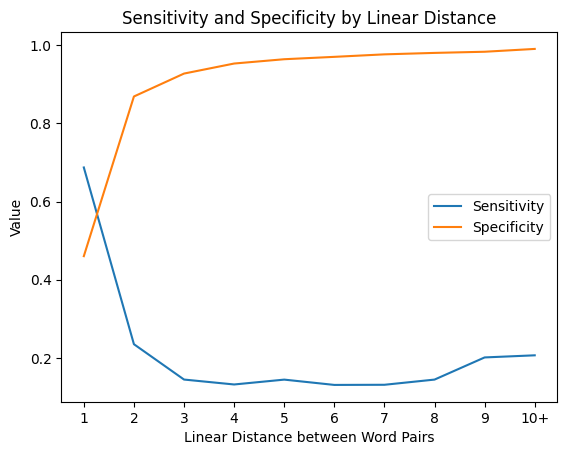

In [170]:
plt.plot(np.arange(len(eval_df)), eval_df["sensitivity"])
plt.plot(np.arange(len(eval_df)), eval_df["specificity"])
plt.xticks(np.arange(len(eval_df)), labels= [str(i) for i in eval_df.index][:len(eval_df) - 1] + ["10+"])
plt.xlabel("Linear Distance between Word Pairs")
plt.ylabel("Value")
plt.title("Sensitivity and Specificity by Linear Distance")
plt.legend(["Sensitivity", "Specificity"])
plt.show()

## Scale up to multiple layers

In [134]:
df_acc = pd.DataFrame(columns=['train_loss', 'val_loss'])
for i in range(12):
    layer = f'blocks.{i}.hook_resid_post'
    if not os.path.exists(f'probe_params/{layer}_probe_params.pt'):
        
        args = {
            'probe': {'maximum_rank': 64, 'params_path': f'probe_params/{layer}_probe_params.pt'},
            'model': {'hidden_dim': 768},
            'device': 'cuda' if torch.cuda.is_available() else 'cpu',
            'probe_training': {'epochs': 20},
            'reporting': {'root': './'}
        }
        probe = TwoWordPSDProbe(args)
        loss_fn = L1DistanceLoss(args)
        regimen = ProbeRegimen(args)

        dataset = SyntaxProbeDataset(sentences_train_edges, 'gpt2-small', layer)
        dataloader = DataLoader(dataset, batch_size=32, collate_fn=custom_collate_fn)

        val_dataset = SyntaxProbeDataset(sentences_val, 'gpt2-small', layer)
        val_dataloader = DataLoader(val_dataset, batch_size=32, collate_fn=custom_collate_fn)

        model = IdentityModel()

        regimen.train_until_convergence(
            probe=probe,
            model=model,
            loss=loss_fn,
            train_dataset=dataloader,
            dev_dataset=val_dataloader
        )
        df_acc.loc[layer] = [regimen.train_losses, regimen.val_losses]
    else: 
        print(f"Probe for layer {layer} already trained, skipping.")


Constructing TwoWordPSDProbe
Loaded pretrained model gpt2-small into HookedTransformer


Processing sentences: 100%|██████████| 10665/10665 [3:13:52<00:00,  1.09s/it]    
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /gpt2/resolve/main/config.json (Caused by NameResolutionError("HTTPSConnection(host=\'huggingface.co\', port=443): Failed to resolve \'huggingface.co\' ([Errno 8] nodename nor servname provided, or not known)"))'), '(Request ID: 96a5c79b-5368-4ae7-8e2b-c406ff57ebed)')' thrown while requesting HEAD https://huggingface.co/gpt2/resolve/main/config.json
Retrying in 1s [Retry 1/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /gpt2/resolve/main/config.json (Caused by NameResolutionError("HTTPSConnection(host=\'huggingface.co\', port=443): Failed to resolve \'huggingface.co\' ([Errno 8] nodename nor servname provided, or not known)"))'), '(Request ID: 9ae1c463-7747-4a21-9145-0f3870269186)')' thrown while requesting HEAD https://huggingface.co/gpt2/res

Loaded pretrained model gpt2-small into HookedTransformer


[training]:   5%|▌         | 1/20 [00:20<06:34, 20.76s/it]

[epoch 0] Train loss: 6.639169433314756, Dev loss: 1.0287776431956874
Saving probe parameters


[training]:  10%|█         | 2/20 [00:27<03:40, 12.25s/it]

[epoch 1] Train loss: 0.9517228183308175, Dev loss: 0.9041996352280243
Saving probe parameters


[training]:  15%|█▌        | 3/20 [00:32<02:32,  8.97s/it]

[epoch 2] Train loss: 0.9053559199108298, Dev loss: 0.9073601293161448


[training]:  20%|██        | 4/20 [00:37<01:58,  7.41s/it]

[epoch 3] Train loss: 0.8269108756629168, Dev loss: 0.8401307661322098
Saving probe parameters


[training]:  25%|██▌       | 5/20 [00:42<01:41,  6.74s/it]

[epoch 4] Train loss: 0.8078932596270154, Dev loss: 0.8316413075612065
Saving probe parameters


[training]:  30%|███       | 6/20 [00:48<01:28,  6.31s/it]

[epoch 5] Train loss: 0.802414873447767, Dev loss: 0.8327511734097316


[training]:  35%|███▌      | 7/20 [00:53<01:16,  5.88s/it]

[epoch 6] Train loss: 0.788683676239028, Dev loss: 0.8262659958143275
Saving probe parameters


[training]:  40%|████      | 8/20 [00:58<01:07,  5.59s/it]

[epoch 7] Train loss: 0.785470195113914, Dev loss: 0.8254165519641925
Saving probe parameters


[training]:  45%|████▌     | 9/20 [01:03<00:59,  5.37s/it]

[epoch 8] Train loss: 0.7839822432942307, Dev loss: 0.8243863583617069
Saving probe parameters


[training]:  50%|█████     | 10/20 [01:07<00:52,  5.22s/it]

[epoch 9] Train loss: 0.7826660542548457, Dev loss: 0.8240090020095245
Saving probe parameters


[training]:  55%|█████▌    | 11/20 [01:12<00:46,  5.14s/it]

[epoch 10] Train loss: 0.781803237872117, Dev loss: 0.823854684125522
Saving probe parameters


[training]:  60%|██████    | 12/20 [01:18<00:42,  5.35s/it]

[epoch 11] Train loss: 0.7812766286614798, Dev loss: 0.8235204603098616
Saving probe parameters


[training]:  65%|██████▌   | 13/20 [01:24<00:38,  5.51s/it]

[epoch 12] Train loss: 0.7799709825296666, Dev loss: 0.8235799364902802


[training]:  70%|███████   | 14/20 [01:29<00:32,  5.39s/it]

[epoch 13] Train loss: 0.782898388901508, Dev loss: 0.8213139180895649
Saving probe parameters


[training]:  75%|███████▌  | 15/20 [01:34<00:25,  5.20s/it]

[epoch 14] Train loss: 0.7820968306908516, Dev loss: 0.8203686698076594
Saving probe parameters


[training]:  80%|████████  | 16/20 [01:39<00:20,  5.07s/it]

[epoch 15] Train loss: 0.7815748327392064, Dev loss: 0.8198049920520702
Saving probe parameters


[training]:  85%|████████▌ | 17/20 [01:43<00:14,  4.95s/it]

[epoch 16] Train loss: 0.7811900033785377, Dev loss: 0.8194912039277926
Saving probe parameters


[training]:  90%|█████████ | 18/20 [01:48<00:09,  4.89s/it]

[epoch 17] Train loss: 0.7808699647641439, Dev loss: 0.8192896764489669
Saving probe parameters


[training]:  95%|█████████▌| 19/20 [01:53<00:04,  4.87s/it]

[epoch 18] Train loss: 0.7806707095160934, Dev loss: 0.8190958217226503
Saving probe parameters


[training]: 100%|██████████| 20/20 [01:58<00:00,  5.92s/it]


[epoch 19] Train loss: 0.7805402186125923, Dev loss: 0.8190221200009439
Constructing TwoWordPSDProbe
Loaded pretrained model gpt2-small into HookedTransformer


Processing sentences:  78%|███████▊  | 8316/10665 [08:27<02:23, 16.39it/s]  


KeyboardInterrupt: 

In [130]:
layer = 'blocks.1.hook_resid_post'

novel_sentences = sentences_test
novel_dataset = SyntaxProbeDataset(novel_sentences, 'gpt2-small', layer)
novel_dataloader = DataLoader(novel_dataset, batch_size = 100, collate_fn=custom_collate_fn)

# Load probe parameters
probe_path = f'probe_params/{layer}_probe_params.pt'
probe.load_state_dict(torch.load(probe_path, map_location=args['device']))

# Make predictions
predictions = regimen.predict(probe, model, novel_dataloader)

Loaded pretrained model gpt2-small into HookedTransformer


[predicting]: 100%|██████████| 21/21 [00:00<00:00, 32.81it/s]


In [131]:
eval_parse_trees(novel_sentences, predictions, batch_size=100)

Overall Accuracy: 0.9481
Total True Positives: 8843, Total True Negatives: 486516, Total False Positives: 13568, Total False Negatives: 13568
Accuracy: 0.9481, Sensitivity: 0.3946, Specificity: 0.9729


(0.9480645747806199, 0.39458301726830575, 0.9728685580822422)

### test for novel sentences

In [132]:
class SyntaxProbeDataset_xx(Dataset):
    def __init__(self, sentences, model_name, layer_name):
        self.sentences = []
        self.activations = []
        self.matrices = []
        model = transformer_lens.HookedTransformer.from_pretrained(model_name)
        for sentence in tqdm(sentences, desc="Processing sentences"):
            text = sentence
            # Get activations
            _, activations = model.run_with_cache([text])
            activation = activations[layer_name].cpu().numpy()[0]
            # Dummy matrix (can be zeros or None)
            mat = np.zeros((activation.shape[0], activation.shape[0]))
            # Store
            self.sentences.append(text)
            self.activations.append(activation)
            self.matrices.append(mat)

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return self.activations[idx], self.matrices[idx]

Loaded pretrained model gpt2-small into HookedTransformer


Processing sentences: 100%|██████████| 1/1 [00:00<00:00,  6.65it/s]


Loaded pretrained model gpt2-small into HookedTransformer
['Can', 'Ġyou', 'Ġlock', 'Ġin', '!']


(array([[0.        , 1.47354388, 0.        , 0.        , 0.        ],
        [1.47354388, 0.        , 2.09182644, 1.61415875, 0.        ],
        [0.        , 2.09182644, 0.        , 0.        , 0.        ],
        [0.        , 1.61415875, 0.        , 0.        , 1.87753415],
        [0.        , 0.        , 0.        , 1.87753415, 0.        ]]),
 <Axes: xlabel='ids', ylabel='root_dist'>)

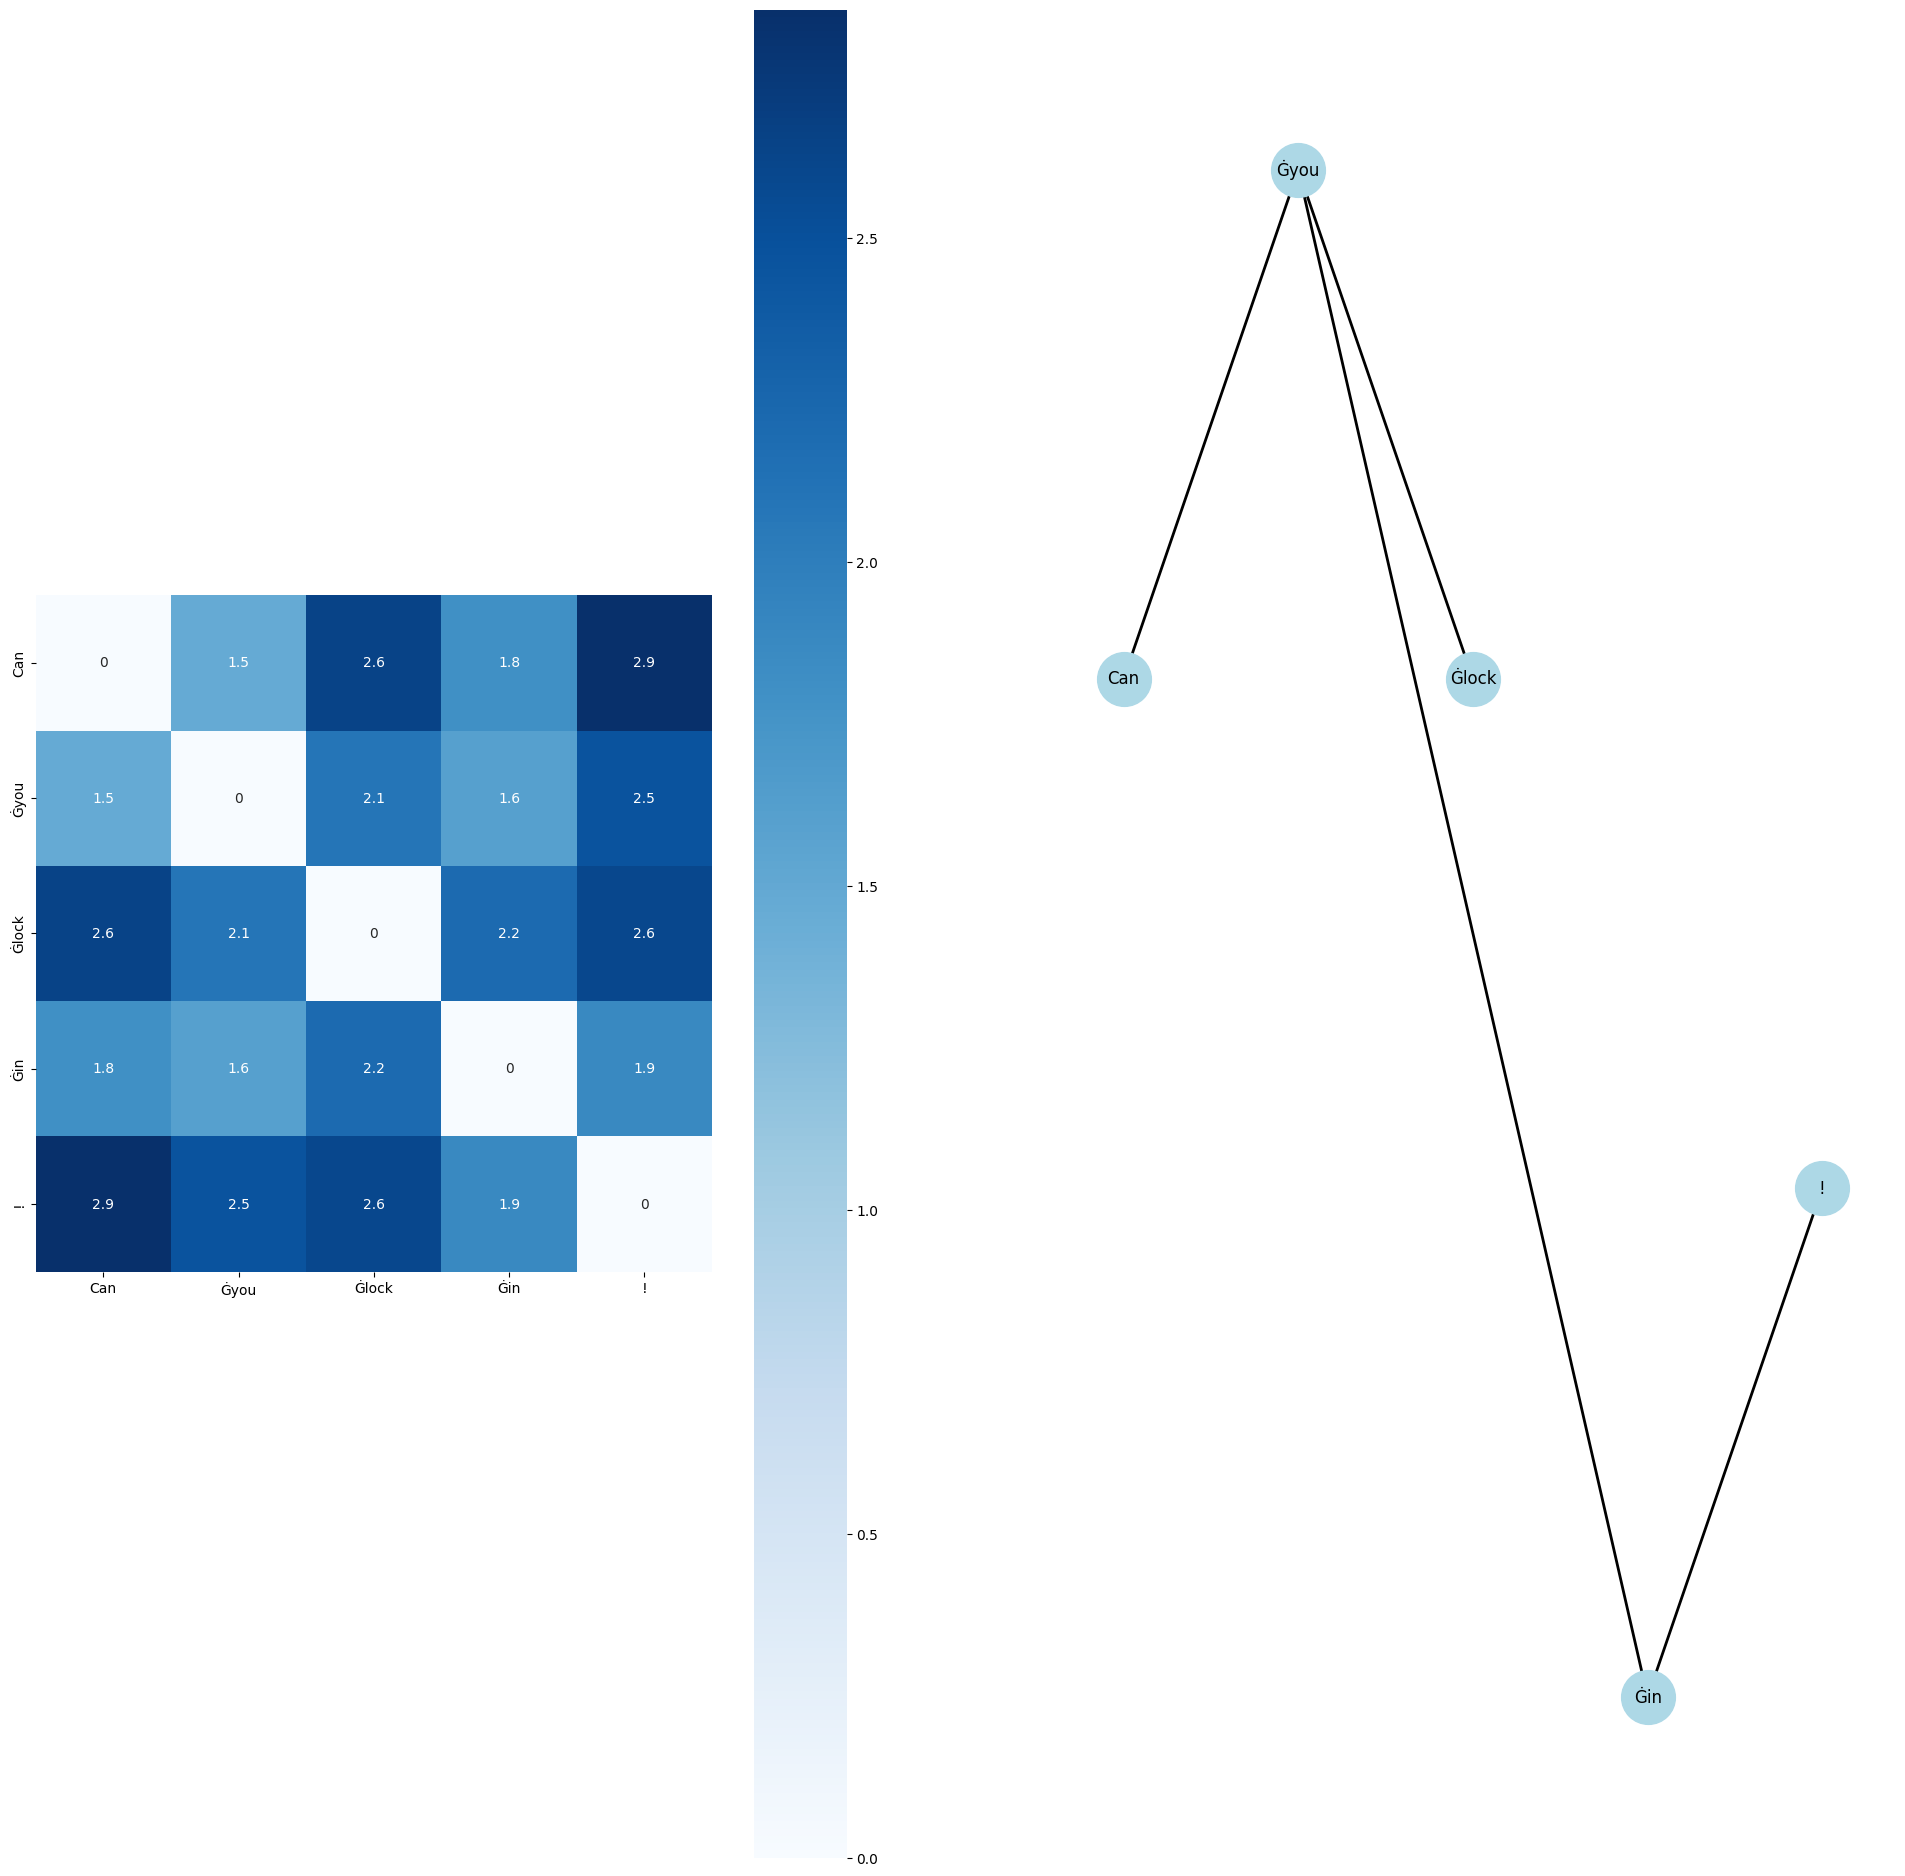

In [133]:
# Prepare your new sentences as a SyntaxProbeDataset and DataLoader
novel_sentences = ["Can you lock in!",]

novel_dataset = SyntaxProbeDataset_xx(novel_sentences, 'gpt2-small', 'blocks.8.hook_resid_post')
novel_dataloader = DataLoader(novel_dataset, batch_size = 100, collate_fn=custom_collate_fn)

tokenizer = transformer_lens.HookedTransformer.from_pretrained('gpt2-small').tokenizer
forms = tokenizer.tokenize(novel_sentences[0])
print(forms)
fig, ax = plt.subplots(1, 2, figsize=(24, 24))
sns.heatmap(predictions[0][0][:len(forms), :len(forms)],square=True, cmap = "Blues", annot = True, 
            xticklabels=forms, yticklabels=forms, ax = ax[0])

graph_from_distance_matrix(predictions[0][0][:len(forms), :len(forms)], ids, root_dist, forms, ax=ax[1])

## Contributions

X did xyz

## References

Hewitt, J., & Manning, C. D. (2019, June). A structural probe for finding syntax in word representations. In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies, Volume 1 (Long and Short Papers) (pp. 4129-4138).

Diego-Simón, P. J., Chemla, E., King, J. R., & Lakretz, Y. (2025). Probing syntax in large language models: Successes and remaining challenges. arXiv preprint arXiv:2508.03211.